#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> "Linear D.S.M Analysis"
 - A Tool for **Modeling** & **Analysis** of **2D Continuous Beams** with **Direct Stiffness Method**
![image-3.png](attachment:image-3.png)

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Post Analysis (Converting +ve directions)
 - Direct Stiffness Method has a +ve direction convension for axial-load, shear and bending-moment which is different from Standard Static +ve direction convensions; and will be corrected.
    
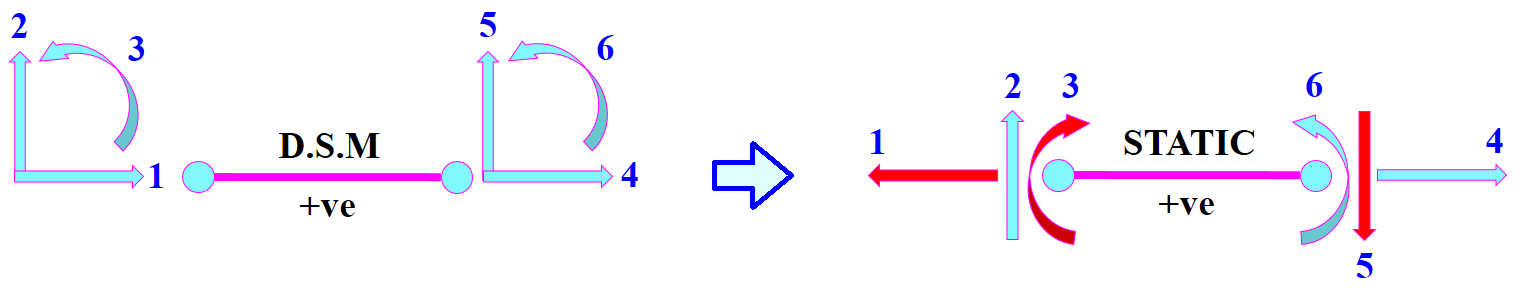
   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Visualizing Support-Reactions
 - **Rx**: horizontal reaction (KN), +ve: left to right
 - **Ry**: vertical reaction (KN), +ve: upward
 - **Rz**: resistant-moment (KNm), +ve: counter-clockwise 
 - left outer support is Support_1
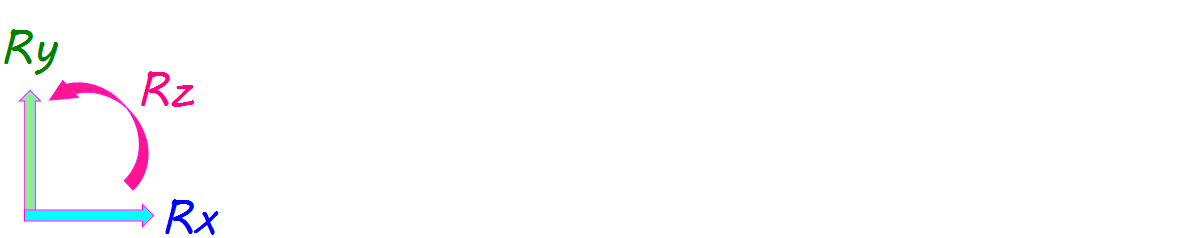


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Libraries

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import copy, pickle

from sympy    import *
from My_Funcs import *

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:deeppink;"> Sections & Dist-Loads & Point-Loads

In [2]:
# rectangular Distributed Load on Beams  (KN/mm)  ---  towards Ground is +ve 
w1 = 292.5/6000;     w2 = 135/4000; 

# Point-Loads on free supports  (KN)  ---  towards Ground is +ve  ---  only on "free" supports. other supports = 0
P1 = 55;         P2 = 25

# sections
# (input)        (auto)      
b,h = 500,900;   s1 = [ b*h, b*h**3/12 ]
b,h = 500,950;   s2 = [ b*h, b*h**3/12 ]
b,h = 600,950;   s3 = [ b*h, b*h**3/12 ]

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:deeppink;"> Structure Data

In [3]:
# (input)
L_tinyBeam  = 100          #  length of tiny beams (mm) --- the smaller the better   

wBay        = [      500   ,   1100  ,  1200   ,   4000   ,   200   ,  300       ]  #  width of bays ( any amount )
W_Beams     = [      w1    ,    w2   ,   w2    ,    w2    ,    w1   ,   w1       ]
Sections    = [      s1    ,    s1   ,   s1    ,    s1    ,    s3   ,   s3       ]
Supports    = ['free' , 'pinned' , 'free' , 'roller' , 'roller' , 'free' , 'free']  # 'fixed' 'pinned' 'roller' 'free'   Note: 'pinned' == 'roller' (Sum(Fx)==0)
Point_Loads = [  P1   ,    0     ,   P2   ,    0     ,    0     ,   0    ,   P2  ]  #  Only on 'free' supports

# (auto)
# material
Ec = 30            # Modulus of Elasticity  ---  Concrete = 30  ---  Steel = 200  ---  (KN/mm2)
nu = 0.0           # Poisson's Rstio  ---  uncracked concrete = 0.2  ---  uncracked concrete = 0.0
Gc = E/(2*(1+nu))  # Shear Modulus   
E_Beams = [ Ec ] * len(wBay)
G_Beams = [ Gc ] * len(wBay)

In [4]:
A, B = [0], [wBay[0]]
for w in wBay[1:]:
    a = B[-1]; A.append(a)
    b = a+w  ; B.append(b)
    
df_Main = pd.DataFrame()
df_Main['Start']   = A
df_Main['Stop' ]   = B
df_Main['wBay' ]   = wBay
df_Main['E']       = E_Beams
df_Main['A']       = [ x[0] for x in Sections ]
df_Main['I']       = [ x[1] for x in Sections ]
df_Main['C']       = Beam_Color( df_Main )   # coloring sections
df_Main['W_Beams'] = W_Beams
df_Main

,Start,Stop,wBay,E,A,I,C,W_Beams
0,0,500,500,30,450000,3.037500e+10,dodgerblue,0.04875
1,500,1600,1100,30,450000,3.037500e+10,dodgerblue,0.03375
2,1600,2800,1200,30,450000,3.037500e+10,dodgerblue,0.03375
3,2800,6800,4000,30,450000,3.037500e+10,dodgerblue,0.03375
4,6800,7000,200,30,570000,4.286875e+10,deeppink,0.04875
5,7000,7300,300,30,570000,4.286875e+10,deeppink,0.04875


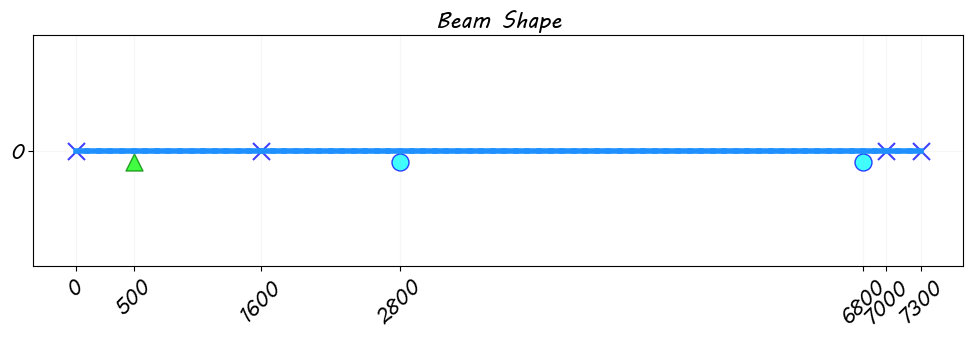

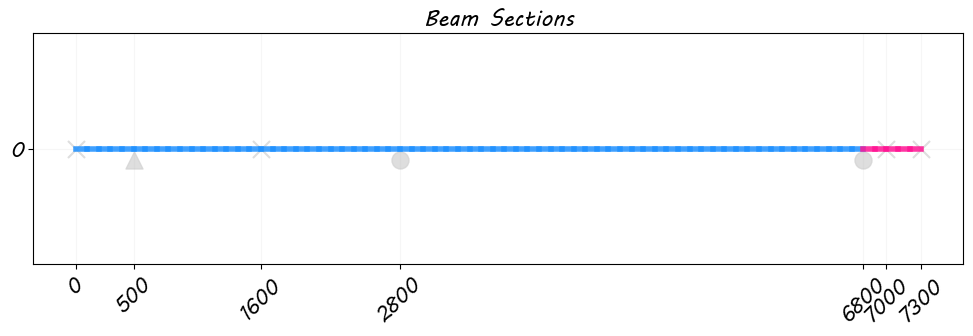

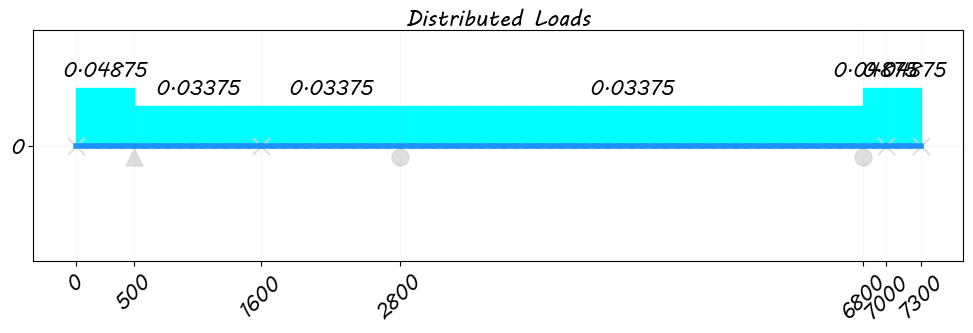

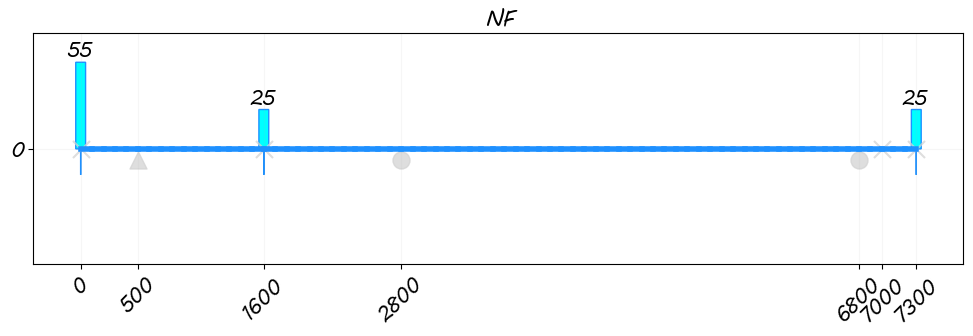

In [5]:
#  multi-sectioning
nBeams_Main, wBay_Main, Supports, Supports_Idx, wBay, nPieces, nBay = MS( wBay, Supports, L_tinyBeam )
# Points & Connectivity Matrices
Points, CnB  =  PC( wBay )

[NOP, NOD, RD, FD, NFD, NB, IndxB] = Static_Coeff( Points, CnB, wBay, Supports )   # Finding Static Coefficients      
Beams        =  Multi_Beams(  E_Beams, Sections, W_Beams, nBeams_Main, nPieces )   # applying  E, A, I, W  to all pieces
Beams['C']   =  Beam_Color(   Beams                                            )   # coloring sections
NF           =  Nodal_Forces( Points,  Point_Loads,  NOD, nBeams_Main, nPieces )   # Nodal Forces


Beam_Shape(           Points, CnB, wBay_Main, wBay, Supports                   )   # checking beams shape
Plot_Sections(        Points, CnB, wBay_Main, wBay, Supports, Beams            )   # checking beams sections
Beam_Dist_Load_Shape( Points, CnB, wBay_Main, wBay, Supports, Beams, W_Beams   )   # checking beams dist. loads
NF_Shape(             Points, CnB, wBay_Main, wBay, Supports, NF               )   # checking beams NFs


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Analysis

In [6]:
# Ke Qf 
KE,QF, LB,TB,keB,KeB,qfB  =  KeQf( Points,  NOD, CnB, NB, IndxB, Beams )

# performing analysis
print('Analysis initiated ...')
qB, R, U = Analyze_Beam( NF,  NOD,  FD, KE,  QF, NB, IndxB, TB, keB, KeB, Beams, qfB )
print('Analysis finished.')


Analysis initiated ...
Analysis finished.


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Post Analysis

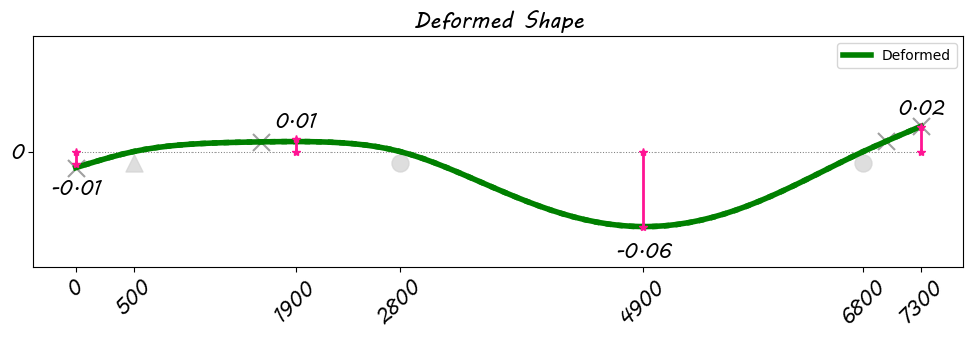

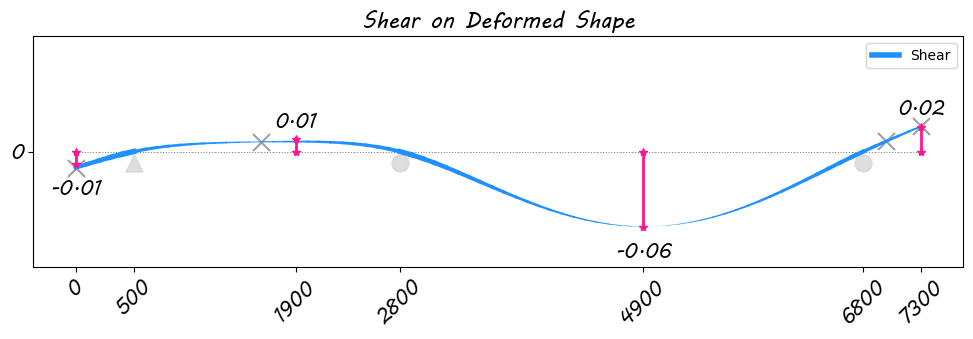

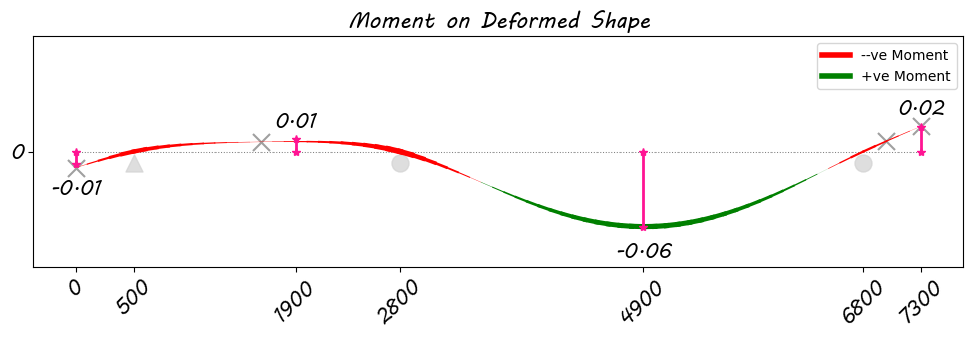

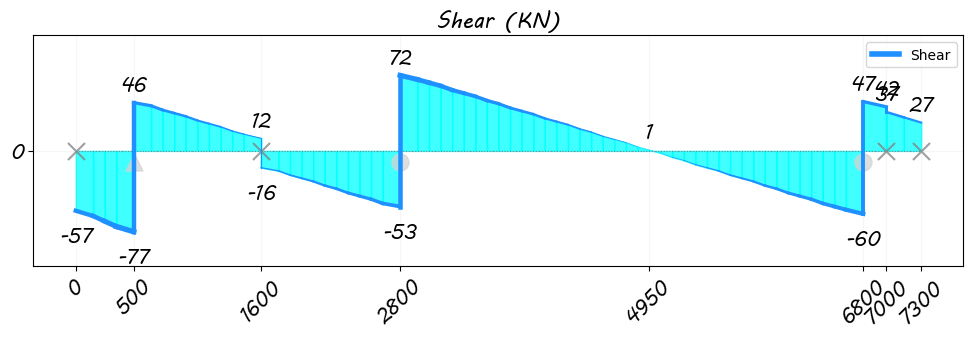

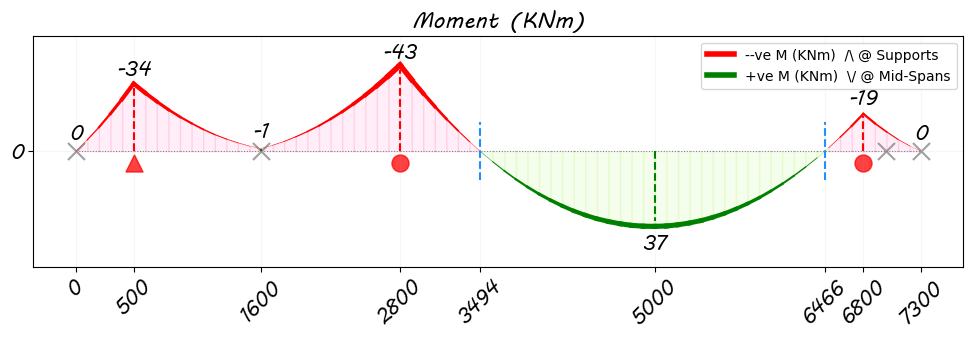

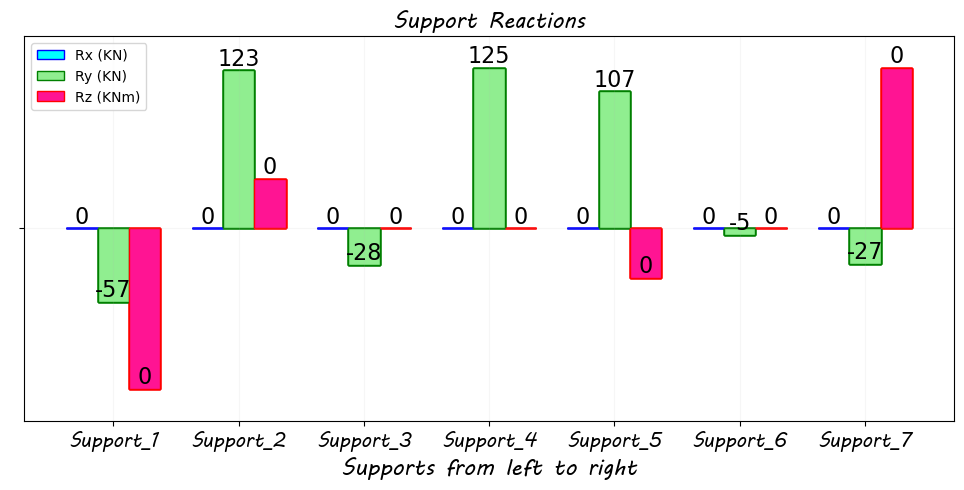

Accuracy  =  96.8 %


In [7]:
# Converting Directions (D.S.M. to Standard.Static) 
# qX  --->  qXs
[ qBs ] = D2S( NB, qB, R )

# finding Global Displacements, Support Reactions & Internal Member Forces
[ Uxyz, Rxyz, AxB,VB,MB ] = xyzNVM( NB, U, R, qBs, nBay )

# Adding Internal Forces to Beams
[ Beams ]  =  Add_member_forces( AxB,VB,MB, Beams )

# finding Max or Min Uy of Main bays
Uy_MxMn = Find_Uy_MxMn( Points, Supports_Idx, Supports, NB, Uxyz )

# plotting deformed-shape
Plot_Deformed( Points, Supports_Idx, Supports, wBay_Main, wBay, Beams, CnB,NB, Uxyz, Uy_MxMn, None );   print()
Plot_Deformed( Points, Supports_Idx, Supports, wBay_Main, wBay, Beams, CnB,NB, Uxyz, Uy_MxMn, 'V'  );   print()
Plot_Deformed( Points, Supports_Idx, Supports, wBay_Main, wBay, Beams, CnB,NB, Uxyz, Uy_MxMn, 'M'  );   print()

# finding 0, Max or Min Shear of Main bays
[ V_Shear, V_MxMn ] = Find_V_MxMn( NB, Beams, Supports_Idx, Supports, wBay_Main, wBay, L_tinyBeam )
# plotting Shear
Plot_Shear( Points, Supports, wBay_Main, wBay, CnB,NB, V_Shear, V_MxMn )

# Finding Flexure Points
Flex = Find_Flexture_Points( Points, NOP, Beams )
# finding  M_MIN @ Supports /\  &  M_MAX @ Mid-Spans \/   of Main bays
[ M_MIN, M_MAX ] = Find_M_MxMn( NOP, NB, Beams )
# plotting Moment
Plot_Moment( Points, Supports, wBay_Main, wBay, CnB,NB,Beams, M_MIN, M_MAX, Flex )

# Visualizing Support Reactions
Plot_Support_Reactions( Rxyz, nPieces )

# Checking Accuracy:   Acc = Sum( Ry ) / Sum( dist. load + Point load )
Accuracy = Find_Accuracy( wBay_Main, W_Beams, Supports, NF, R )
print( 'Accuracy  =  ' + str(Accuracy) + ' %' )

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:deeppink;"> Moment Re-Distribution

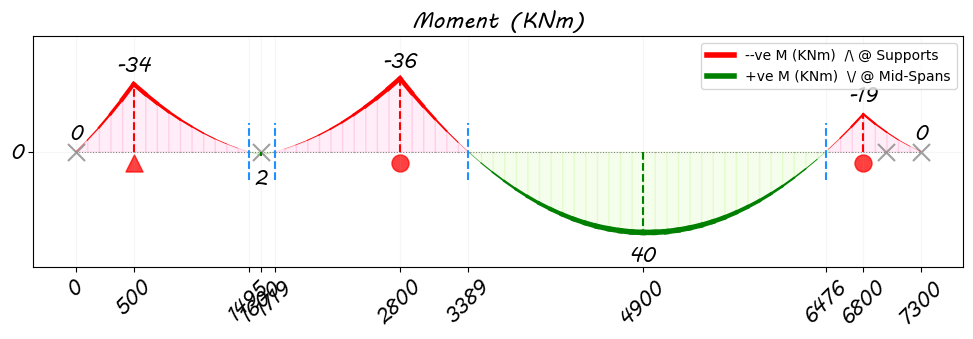

In [8]:
# (input)
redist = 0.15

# (auto)
M_redist                       = Moment_Redistribute( Supports_Idx, Supports, Beams, redist )
Flex_redist                    = Find_Flexture_Points( Points, NOP, M_redist )
[ M_MIN_redist, M_MAX_redist ] = Find_M_MxMn( NOP, NB, M_redist )
#Plot_Moment( Points, Supports, wBay_Main, wBay, CnB,NB,Beams   , M_MIN       , M_MAX       , Flex        )   # before redist
Plot_Moment(  Points, Supports, wBay_Main, wBay, CnB,NB,M_redist, M_MIN_redist, M_MAX_redist, Flex_redist )   # after  redist

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:deeppink;"> Moment Re-Distribution

In [9]:
def df_Main_with_Redist(df_Main, Beams, Supports_Idx, NB):
    
    df_Main['Shear_left' ] = Beams.loc[    np.array(Supports_Idx[  :-1]), 'Shear_left'  ].tolist()
    df_Main['Shear_right'] = Beams.loc[ -1+np.array(Supports_Idx[+1:  ]), 'Shear_right' ].tolist()

    M = Beams.loc[    Supports_Idx[:-1], 'Moment_left' ].tolist() + Beams.loc[    [NB-1], 'Moment_right' ].tolist()
    df_Main['Moment_left' ] = M[:-1]
    df_Main['Moment_right'] = M[+1:]

    M = M_redist.loc[ Supports_Idx[:-1], 'Moment_left' ].tolist() + M_redist.loc[ [NB-1], 'Moment_right' ].tolist()
    df_Main['Moment_left redist' ] = M[:-1]
    df_Main['Moment_right redist'] = M[+1:]

    VL, VR = [], []
    for i in df_Main.index:
        dv = df_Main.loc[i,'Shear_right' ] - df_Main.loc[i,'Shear_left' ]
        dm = df_Main.loc[i,'Moment_right redist'] - df_Main.loc[i,'Moment_left redist']
        L  = df_Main.loc[i,'wBay']
        vl = dm/L - dv/2;   vl = int(np.round(vl,0));   VL.append(vl)
        vr = dm/L + dv/2;   vr = int(np.round(vr,0));   VR.append(vr)
    df_Main['Shear_left redist' ] = VL
    df_Main['Shear_right redist'] = VR
    
    return df_Main

df_Main = df_Main_with_Redist(df_Main, Beams, Supports_Idx, NB)
df_Main

,Start,Stop,wBay,E,A,I,C,W_Beams,Shear_left,Shear_right,Moment_left,Moment_right,Moment_left redist,Moment_right redist,Shear_left redist,Shear_right redist
0,0,500,500,30,450000,3.037500e+10,dodgerblue,0.04875,-57,-77,0,-33600,0,-33600,-57,-77
1,500,1600,1100,30,450000,3.037500e+10,dodgerblue,0.03375,46,12,-33600,-1400,-33600,1670,49,15
2,1600,2800,1200,30,450000,3.037500e+10,dodgerblue,0.03375,-16,-53,-1400,-42800,1670,-36380,-13,-50
3,2800,6800,4000,30,450000,3.037500e+10,dodgerblue,0.03375,72,-60,-42800,-18600,-36380,-18600,70,-62
4,6800,7000,200,30,570000,4.286875e+10,deeppink,0.04875,47,42,-18600,-9700,-18600,-9700,47,42
5,7000,7300,300,30,570000,4.286875e+10,deeppink,0.04875,37,27,-9700,0,-9700,0,37,27


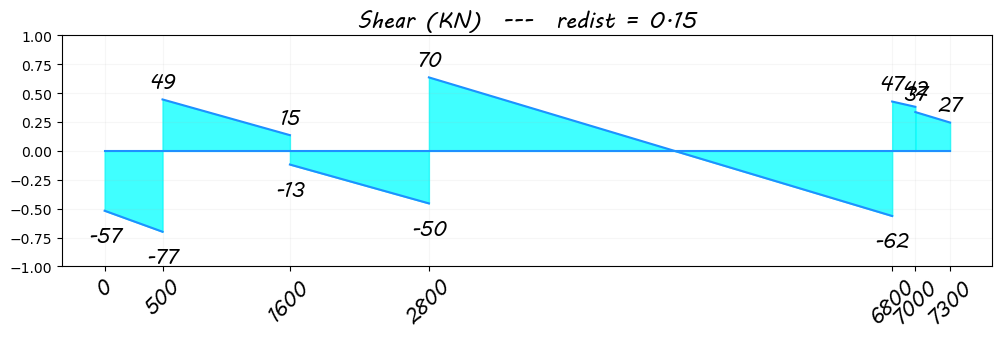

In [10]:
def Plot_Shear_Redist( df_Main ):
    
    VL_MAX = abs(df_Main['Shear_left redist' ]).max()
    VR_MAX = abs(df_Main['Shear_right redist']).max()
    V_MAX  = max(VL_MAX,VR_MAX)

    fig, ax = plt.subplots( figsize=(12,3) )
    ax.plot( [0,df_Main['wBay'].sum()], [0,0], 'dodgerblue' )
    for i in df_Main.index:
        xl, xr = df_Main.loc[i,['Start','Stop']].tolist()
        vl, vr = df_Main.loc[i,['Shear_left redist','Shear_right redist']].tolist()
        X = [ xl, xr ]
        V = [ .7*vl/V_MAX, .7*vr/V_MAX ]
        ax.plot(X,V,'dodgerblue')
        ax.fill_between( X, [0,0], V, color='cyan', alpha=0.75 )
        if   V[0]>=0:  plt.text( X[0], V[0]+.10, str(vl), ha='center', font='MV BOLI', fontsize=14 )
        if   V[0]<=0:  plt.text( X[0], V[0]-.27, str(vl), ha='center', font='MV BOLI', fontsize=14 )
        if   V[1]>=0:  plt.text( X[1], V[1]+.10, str(vr), ha='center', font='MV BOLI', fontsize=14 )
        if   V[1]<=0:  plt.text( X[1], V[1]-.27, str(vr), ha='center', font='MV BOLI', fontsize=14 )
    
    # title
    plt.title( 'Shear (KN)  ---  redist = '+str(redist), font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in df_Main['wBay']:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    Xwalk = list( set( Xwalk + X ))
    xtks = np.array(Xwalk,dtype='f8') 
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14)
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Shear_with_redist.png', dpi=120) 
    plt.show()
    
    return None

Plot_Shear_Redist( df_Main )

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Save

In [11]:
pickle.dump( Uy_MxMn,  open('Uy_MxMn','wb') )  # save
pickle.dump( V_MxMn ,  open('V_MxMn' ,'wb') )  # save
pickle.dump( Flex   ,  open('Flex'   ,'wb') )  # save
pickle.dump( M_MIN  ,  open('M_MIN'  ,'wb') )  # save
pickle.dump( M_MAX  ,  open('M_MAX'  ,'wb') )  # save
pickle.dump( Rxyz   ,  open('Rxyz'   ,'wb') )  # save

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Load

In [12]:
Uy_MxMn = pickle.load( open('Uy_MxMn','rb') )  # load
V_MxMn  = pickle.load( open('V_MxMn' ,'rb') )  # load
Flex    = pickle.load( open('Flex'   ,'rb') )  # load
M_MIN   = pickle.load( open('M_MIN'  ,'rb') )  # load
M_MAX   = pickle.load( open('M_MAX'  ,'rb') )  # load
Rxyz    = pickle.load( open('Rxyz'   ,'rb') )  # load

##### 

##### 